In [3]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import math

## Aufgabe 2/3

(-0.5, 99.5, 99.5, -0.5)

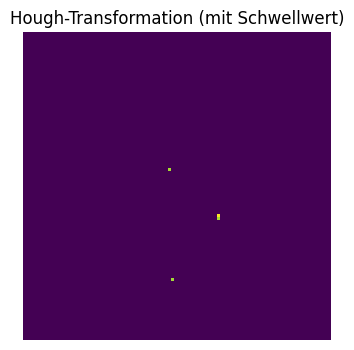

In [ ]:
img = io.imread("noisy-lines.tif")

def rgb_2_gray(img, mode='lut'):
    if img.ndim == 2:
        # Bild ist schon in grayscale
        return img
    elif img.ndim == 3:
        if mode == 'lut':
            return np.round(img[:,:,0] * 0.2126 + img[:,:,1] * 0.7152 + img[:,:,2] * 0.0722)
        else:
            return np.round(img[:,:,0] * 0.2126 + img[:,:,1] * 0.587 + img[:,:,2] * 0.114)

# binarisieren
def sobel(img, filter):
    height, width = img.shape
    filter_h, filter_w = filter.shape

    s = 1.0 if np.sum(filter) == 0 else 1.0 / np.sum(filter)

    # filter matrix (2K+1)×(2L+1) (radius)
    K = filter_w // 2
    L = filter_h // 2

    filtered_img = np.zeros((height - 2 * K, width - 2 * L))

    for v in range(L, height - L):  #über Zeilen
        for u in range(K, width - K):  #über Spalten
            value = 0.0
            for j in range(-L, L + 1):  #über Filterzeilen
                for i in range(-K, K + 1):  #über Filterspalten
                    value += img[v + j, u + i] * filter[j + L , i + K]
            filtered_img[v - L , u - K] = s * value

    filtered_img = np.clip(filtered_img, 0, 255).astype(np.uint8)

    return filtered_img

filter_x = np.array([[ -1,  0,  1],
                     [ -2,  0,  2],
                     [ -1,  0, 1]])

filter_y = np.array([[ -1, -2, -1],
                     [  0,  0, 0],
                     [  1,  2, 1]])

gray = rgb_2_gray(img)
edges_x = sobel(gray, filter_x)
edges_y = sobel(gray, filter_y)
edges = np.hypot(edges_x, edges_y)
binary_image = (edges > 50).astype(np.uint8)  # Schwellenwert 

# Hough-Transformation
def linearHT(im_edge, angle_steps, radius_stepsize):
    height, width = im_edge.shape
    x_ctr = width // 2
    y_ctr = height // 2

    nAng = angle_steps
    dAng = math.pi / nAng

    nRad = radius_stepsize
    r_max = math.hypot(x_ctr, y_ctr)
    dRad = (2*r_max) / nRad

    hough_array = np.zeros((nAng, nRad), dtype=int)


    # Begüm my guy passt der Schwellwert so?
    threshold_rate = 0.85

    # Hough-Akkumulator
    for v in range(height):
        for u in range(width):
            if im_edge[v,u] > 0:  # nur Kantenpixel berücksichtigen
                # vom Mittelpunkt berechnen (macht HT symmetrischer)
                x = u-x_ctr
                y = v-y_ctr
                for a in range(nAng):
                    theta = dAng * a  # aktuellen Winkel 𝜃 berechnen
                    r = (x*math.cos(theta) + y*math.sin(theta)) / dRad  # Hesse'sche NF
                    r_idx = int(round(r+nRad/2))  # in pos Bereich verschieben
                    if 0 <= r_idx < nRad:
                        # Gerade wird von weiterem Kantenpunkt unterstützt (mit gleichem Winkel und Radius)
                        hough_array[a, r_idx] += 1


    # Schwellwertoperation
    max_value = np.max(hough_array)
    threshold = max_value*threshold_rate
    hough_array[hough_array < threshold] = 0

    return hough_array


houghArray = linearHT(binary_image, 100, 100)

plt.figure(figsize=(12, 4))
plt.title("Hough-Transformation (mit Schwellwert)")
plt.imshow(houghArray)
plt.axis('off')


## Aufgabe 4
 a) Wie können die Kanten im ursprünglichem Bild mit dieser Schwelloperation ermittelt werden?
- die Schwellwertopertion filtert starke Kantenverläufe -> stark Kanten können so im Bild hervorgehoben werden
b) Welches sind die dominierendsten (längsten) Kanten?
- die, die nach dem Setzen des Schwellwerts noch existieren
 c) Anstelle der Schwelloperation könnte auch die Methode der Non-Maximum Suppression verwendet werden, um die Punkte im HoughArray detektieren zu können. Beschreiben Sie diese Methode kurz.
 - durch sie findet man lokale Maxima im Akkumulator-Array durch die Unterdrückung nicht aller maximaler Werte auf.
 -> es wird Zellenweise festgestellt, ob der Wert höher ist als die Werte aller Nachbarzellen (bestehender Wert wird beibehalten)